## Refinement of part of an existing grid

The main source of complexity is removing the existing section of grid in 
a way that respects the invariants of the paving algorithm.  

In [106]:
import paver
import trigrid
import matplotlib.pyplot as plt
import numpy as np
import field

%matplotlib notebook

populate_dt: top
populate_dt: adding points
populate_dt: 0/13728
populate_dt: add constraints
populate_dt: 0/38991
populate_dt: end


<IPython.core.display.Javascript object>


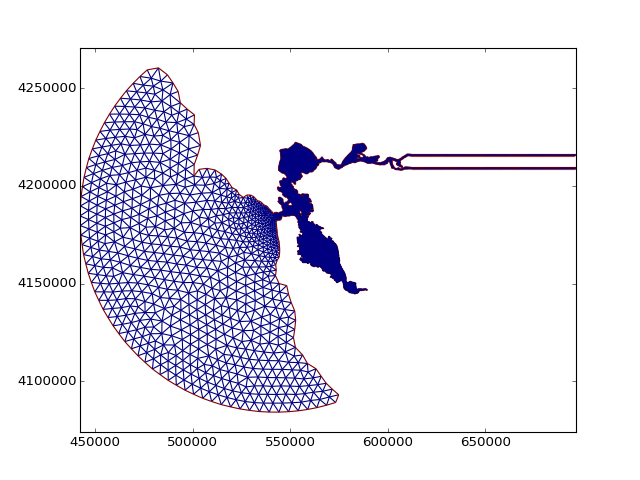

In [124]:
# Load and display a 25k cell grid of San Francisco Bay
p=paver.Paving(suntans_path='/home/rusty/models/suntans/spinupdated/rundata/original_grid')

fig,ax=plt.subplots()
p.tg_plot() ;

Remove the nodes/edges where the refinement is needed.  In this example,
we define a new density field telescoping out
from the Farallon Islands.  This area started at about 4km resolution,
and will now be 2km.  This density field will be used both to select
which existing geometries must be removed (i.e. edges longer than the 
density field), and to control the scale during repaving.

Constructing Apollonius Graph.  quantize=False
        0 /        1
            0.000000,0.000000,-20000.000000
Done!


<IPython.core.display.Javascript object>


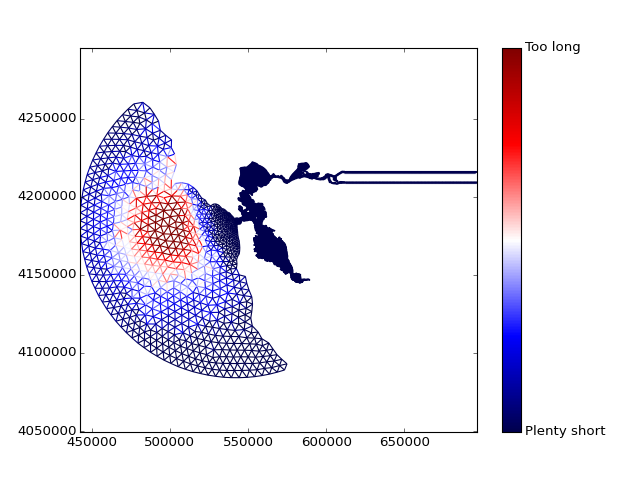

In [113]:
# create the refined density field:
dens=field.ApolloniusField(X=np.array( [[500e3,4.18e6]] ), # Farallons coords
                           F=np.array( [2000.0] ) )        # at 2km

# compare that to linear scale of existing edges
segments=p.points[p.edges[:,:2]] # [Nedge, endpoints, {x,y}]
edge_lengths=np.sqrt(np.sum(np.diff(segments,axis=1)**2,axis=-1)[:,0])
edge_centers=np.mean(segments,axis=1)
dens_at_edge=dens(edge_centers)
score=edge_lengths / dens_at_edge

# See what that looks like
fig,ax=plt.subplots()
coll=p.tg_plot(ax=ax,edge_values=score)
coll.set_cmap('seismic')
coll.set_clim([0.5,1.5])
cbar=plt.colorbar(coll,ticks=[0.5,1.5])
cbar.set_ticklabels(['Plenty short','Too long'])

Remove edges which are significantly longer than the target resolution.  There
are a few issues to keep in mind here:
 - `delete_edge()` must be called with `handle_unpaved=True`.  This option is only available when directly deleting edges, which means that you can't just delete nodes and have that cascade to deleting adjacent edges (though there's no reason this couldn't be exposed in `delete_node`)
 - it's easiest to avoid boundaries.  The code below will leave all boundary edges alone, but if the new density is significantly different than the existing scale along the boundaries the generation step may fail.  In that case, it would be necessary to call `infer_original_rings()`, which enables sliding/resampling of nodes along the boundary.
 - some approaches for choosing which edges to delete can leave edges stranded, disconnected from the rest of the grid.  This *shouldn't* be a problem, but sometimes it exposes bugs.
 - be sure to remove nodes in the area of refinement as well.  It's not sufficient to just remove the edges and cells.

populate_dt: top
populate_dt: adding points
populate_dt: 0/13728
populate_dt: add constraints
populate_dt: 0/38991
populate_dt: end


<IPython.core.display.Javascript object>


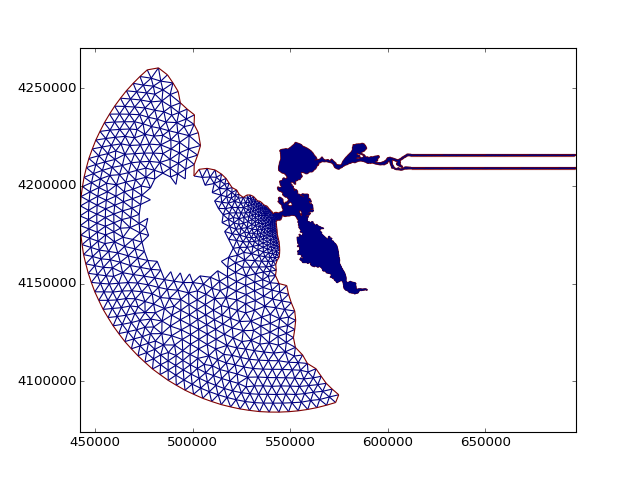

In [144]:
# Load the grid again, since this step can require some iteration
p=paver.Paving(suntans_path='/home/rusty/models/suntans/spinupdated/rundata/original_grid')

# This approach is more awkward than testing edge length directly, but
# doesn't leave stranded edges.

# 0.6 is an approximation of sqrt(cell area) -> side length, plus
# some cushion
bad_cells=np.sqrt(p.areas())> 0.7*dens( p.vcenters() )
bad_edges= np.all( (p.edges[:,3:]!=trigrid.BOUNDARY)&bad_cells[p.edges[:,3:]], 
                  axis=1)

orphan_nodes=set()
for e in np.nonzero(bad_edges)[0]:
    orphan_nodes.add(p.edges[e,0])
    orphan_nodes.add(p.edges[e,1])
    p.delete_edge(e,handle_unpaved=1)

for n in orphan_nodes:
    if len(p.pnt2edges(n))==0:
        p.delete_node(n)
        
fig,ax=plt.subplots()
coll=p.tg_plot(ax=ax)

In [103]:
long_edges = np.nonzero((score>1.2) )[0] # i.e. edges 20% longer than desired
nodes_to_kill=np.unique(p.edges[long_edges,:2]) 

for n in nodes_to_kill:
    on_boundary=False
    local_edges=list(p.pnt2edges(n)) # copy, as it will change
    for e in local_edges:
        if p.edges[e,4]==trigrid.BOUNDARY:
            on_boundary=True
        else:
            p.delete_edge(e,handle_unpaved=1)
    if not on_boundary:
        p.delete_node(n)
fig,ax=plt.subplots()
coll=p.tg_plot(ax=ax)

populate_dt: top
populate_dt: adding points
populate_dt: 0/13728
populate_dt: add constraints
populate_dt: 0/38991
populate_dt: end


In [145]:
p.density=dens
p.pave_all(n_steps=np.inf)

d_boundary 13856 => 13875 = 4169.32 vs line 3206.37
CAREFUL: allowing a nonlocal connection to a nearby node, but okay(?) b/c of distances
bisect_nonlocal is about to resample preemptively
bisect_nonlocal is about to add an edge
bisect_nonlocal got cells [25604] from new edge
Iters are from the same ring - will split that ring in two
Splitting boundary, made it back to b_iter.  good.
No more rings need paving!
Done!


<IPython.core.display.Javascript object>


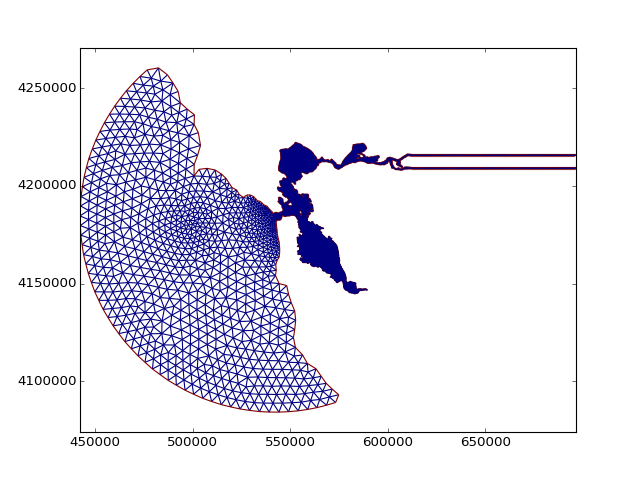

In [146]:
fig,ax=plt.subplots()
coll=p.tg_plot(ax=ax)